In [7]:
import numpy as np
import pandas as pd
import scipy as scp


import matplotlib.pyplot as plt
%matplotlib inline

import astropy
from astropy.io.votable import parse
from astropy import units as u
from astropy.coordinates import SkyCoord

## data import

In [3]:
from astroquery.vizier import Vizier


VizOC = Vizier(catalog="J/A+A/659/A59/table2")
VizOC.ROW_LIMIT = -1

cluster = "Blanco_1"
OC_df = VizOC.query_constraints(Cluster=cluster).values()[0].to_pandas()

## building density profile

Text(0, 0.5, 'pmdec')

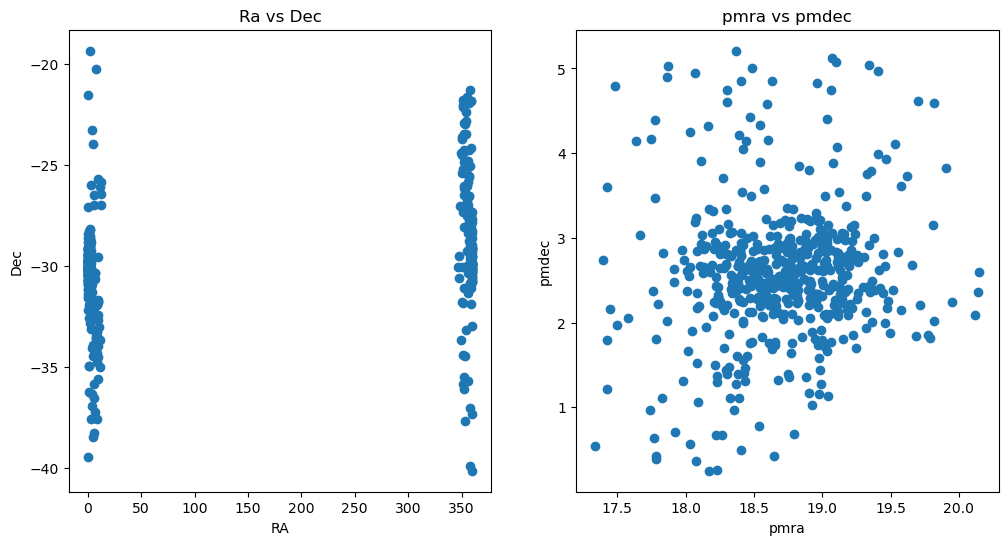

In [5]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

ax[0].scatter(OC_df['RA_ICRS'],OC_df['DE_ICRS'],label='Blanco_1')
ax[1].scatter(OC_df['pmRA'],OC_df['pmDE'],label='Blanco_1')

ax[0].set_title('Ra vs Dec')
ax[1].set_title('pmra vs pmdec')

ax[0].set_xlabel('RA')
ax[0].set_ylabel('Dec')

ax[1].set_xlabel('pmra')
ax[1].set_ylabel('pmdec')

In [8]:
#converting eq to cartesian
blanco_1_eq_coords = SkyCoord(ra=OC_df['RA_ICRS']*u.degree, dec=OC_df['DE_ICRS']*u.degree, distance=1000/OC_df['plx'], frame='icrs')

#defining cartesian arrays
blanco_1_cart_coords = blanco_1_eq_coords.cartesian.x,blanco_1_eq_coords.cartesian.y,blanco_1_eq_coords.cartesian.z

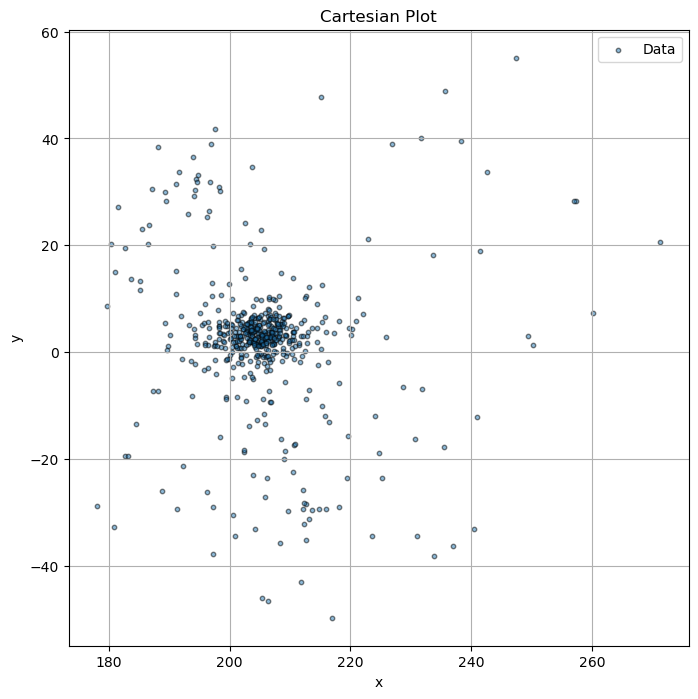

In [9]:
plt.figure(figsize=(8,8))
plt.scatter(blanco_1_cart_coords[0],blanco_1_cart_coords[1],label='Data',s=10,alpha=0.5,edgecolors='k')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Cartesian Plot')
plt.legend()
plt.grid()

Text(0.5, 0, 'z')

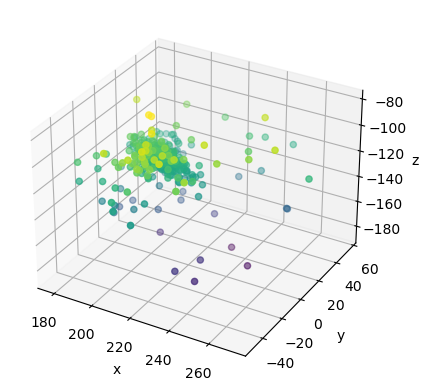

In [10]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(blanco_1_cart_coords[0], blanco_1_cart_coords[1], blanco_1_cart_coords[2], 
c=blanco_1_cart_coords[2], cmap='viridis');

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

In [ ]:
#the profile functions

def Kings_profile(rho_0,r,r_c,r_t):
    rho_k = rho_0 * (((1+(r/r_c)**2)**-0.5 - (1+(r_t/r_c)**2)**-0.5)**2)
    return rho_k

def Plummers_profile(rho_0,r,a):
    rho_P = rho_0 * ((1+((r/a)**2))**2)
    return rho_P

def Zhao_profile(rho_0,r,a,beta):
    rho = rho_0*((r/a)**-1)*((1+(r/a)**2)**((1-beta)/2))
    return rho

## fit different functions

## compare models

## HOORAY!!!